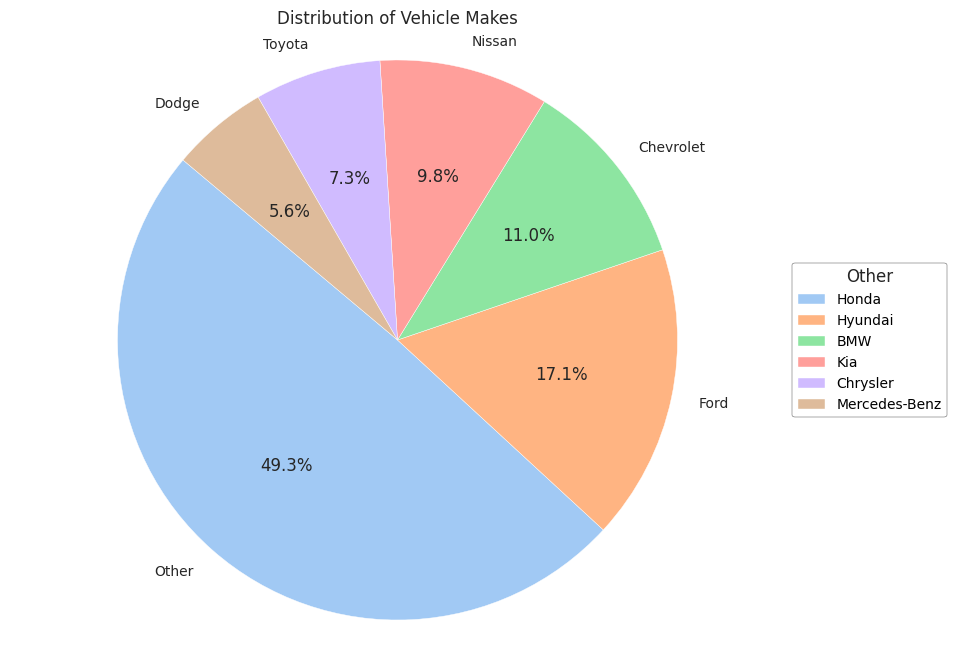

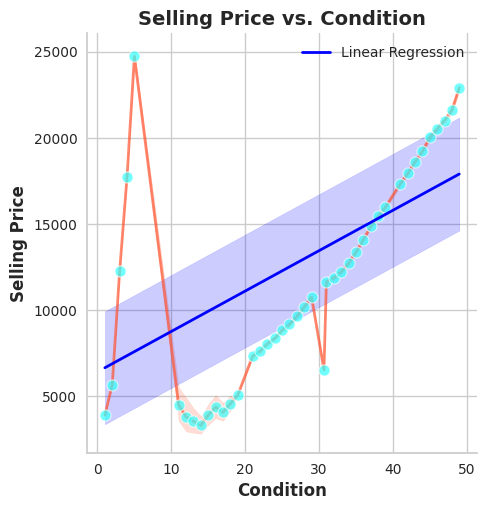

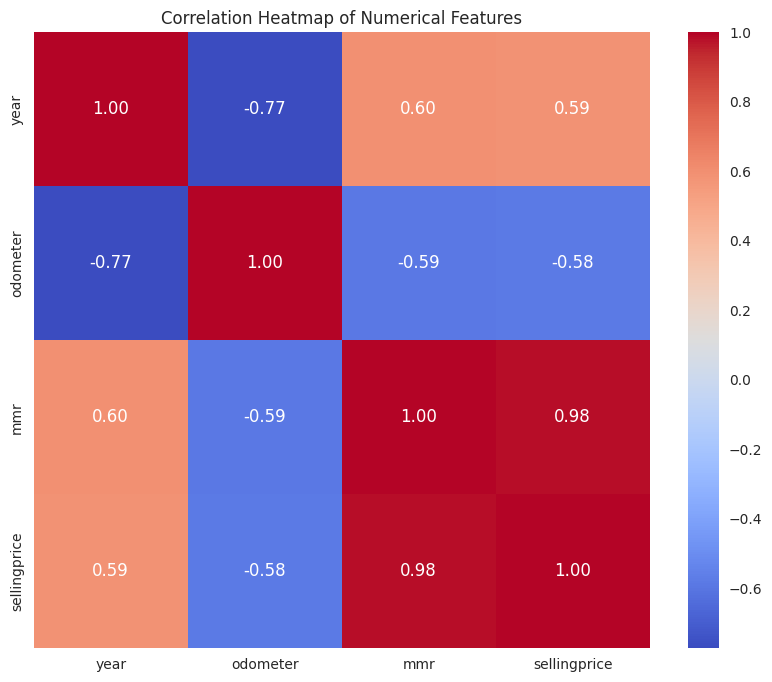

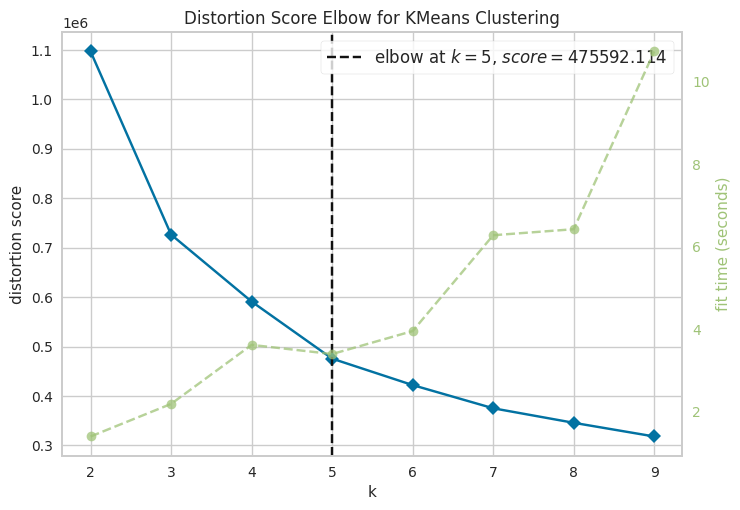

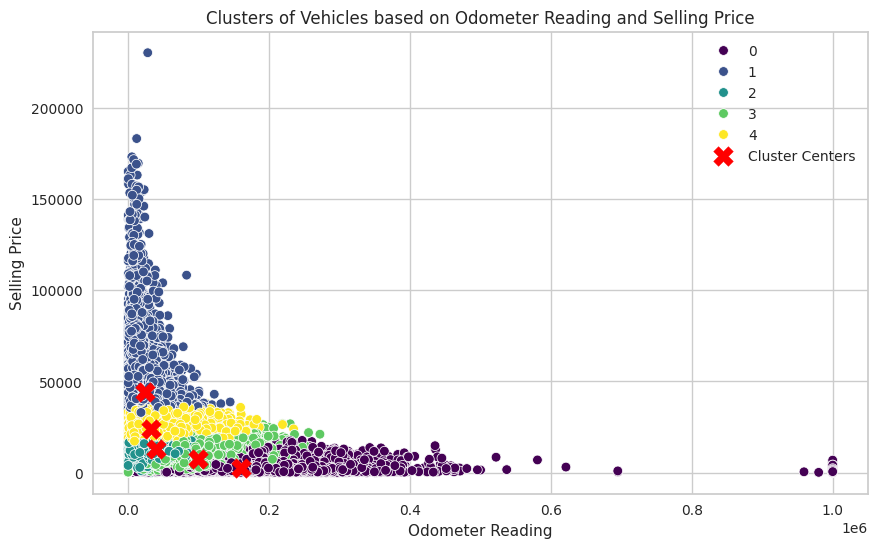

Silhouette Score: 0.37530890747584245


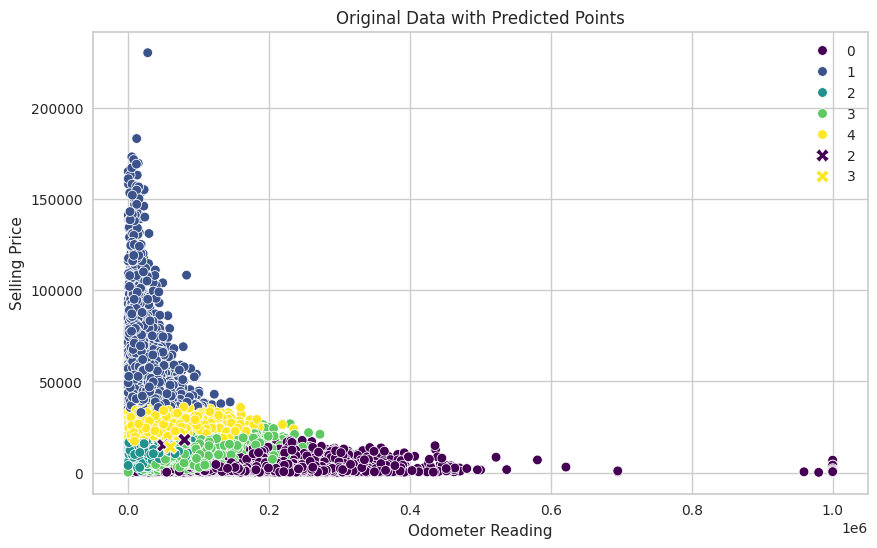

Predicted Cluster Labels for New Data:
   year  odometer    mmr  sellingprice  cluster_label
0  2010     50000   8000         15000              2
1  2015     80000  10000         18000              2
2  2008     60000   7000         14000              3
Statistical Measures:
                      mean   median           std  skewness   kurtosis
year           2010.038864   2012.0      3.966882 -1.183197   1.010436
odometer      68320.652287  52268.0  53394.432256  1.843324  13.551518
mmr           13769.377495  12250.0   9679.741985  1.997691  11.444000
sellingprice  13611.358810  12100.0   9749.501628  1.953444  11.114646


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
from sklearn.metrics import silhouette_score

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define scaler and kmeans globally
scaler = StandardScaler()
kmeans = None

def plot_pie_chart(df):
    make_counts = df['make'].value_counts()
    threshold = 0.05 * len(df)
    small_categories = make_counts[make_counts < threshold].index
    df['make'] = df['make'].replace(small_categories, 'Other')
    make_percentage = (df['make'].value_counts(normalize=True) * 100).round(1)

    pie_colors = sns.color_palette('pastel')[0:len(make_percentage)]

    plt.figure(figsize=(10, 8))
    patches, _, _ = plt.pie(make_percentage, labels=make_percentage.index, autopct='%1.1f%%', colors=pie_colors, startangle=140)
    plt.title('Distribution of Vehicle Makes')
    plt.axis('equal')

    plt.legend(title='Other', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, facecolor='white', edgecolor='black', labelcolor='black', handlelength=2, labels=make_counts[make_counts < threshold].index)
    plt.savefig('pie_chart.png', bbox_inches='tight')
    plt.show()

def plot_line_graph(df):
    sns.set_style("whitegrid")

    line_color = "#FF5733"
    point_color = "#33FFFC"

    # Impute missing values in 'condition' with mean
    imputer = SimpleImputer(strategy='mean')
    df['condition'] = imputer.fit_transform(df[['condition']])

    # Drop rows with missing values in 'sellingprice'
    df.dropna(subset=['sellingprice'], inplace=True)

    # Plot line graph
    sns.relplot(
        x="condition",
        y="sellingprice",
        color=line_color,
        kind="line",
        data=df,
        linewidth=2,
        marker="o",
        markersize=8,
        alpha=0.7,
        dashes=False,
        legend="full",
        markerfacecolor=point_color,
    )

    # Fit a linear regression model
    model = LinearRegression()
    X = df[['condition']]
    y = df['sellingprice']
    model.fit(X, y)

    # Plot the line of best fit with confidence intervals
    x_values = pd.DataFrame({'condition': np.linspace(df['condition'].min(), df['condition'].max(), 100)})
    preds = model.predict(x_values)
    plt.plot(x_values, preds, color='blue', linewidth=2, label='Linear Regression')
    plt.fill_between(x_values['condition'], preds - np.std(preds), preds + np.std(preds), color='blue', alpha=0.2)

    plt.xlabel("Condition", fontsize=12, fontweight="bold")
    plt.ylabel("Selling Price", fontsize=12, fontweight="bold")
    plt.title("Selling Price vs. Condition", fontsize=14, fontweight="bold")
    plt.legend(loc='upper right')
    plt.savefig('line_graph_with_line_of_best_fit.png', bbox_inches='tight')
    plt.show()

def plot_heatmap(df):
    numerical_features = ['year', 'odometer', 'mmr', 'sellingprice']
    correlation_matrix = df[numerical_features].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Correlation Heatmap of Numerical Features')
    plt.legend(loc='upper right')
    plt.savefig('heatmap.png', bbox_inches='tight')
    plt.show()

def plot_elbow_plot(df):
    global kmeans

    # Impute missing values in the DataFrame
    numerical_features = ['year', 'odometer', 'mmr', 'sellingprice']
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df[numerical_features]), columns=numerical_features)

    # Normalize the numerical features
    df_scaled = scaler.fit_transform(df_imputed[numerical_features])

    # Perform clustering using the elbow method
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,10))
    visualizer.fit(df_scaled)
    visualizer.show()

    # Determine the optimal number of clusters
    n_clusters = visualizer.elbow_value_

    # Perform KMeans clustering with the optimal number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(df_scaled)

    # Back-scale cluster centroids
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Add cluster labels to the original DataFrame
    df['cluster_label'] = kmeans.labels_

    # Plot clustered data with appropriate colors and labels
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='odometer', y='sellingprice', hue='cluster_label', palette='viridis')
    plt.scatter(cluster_centers[:, 1], cluster_centers[:, 3], marker='X', color='red', s=200, label='Cluster Centers')
    plt.title('Clusters of Vehicles based on Odometer Reading and Selling Price')
    plt.xlabel('Odometer Reading')
    plt.ylabel('Selling Price')
    plt.legend(loc='upper right')
    plt.savefig('scatter_plot.png', bbox_inches='tight')
    plt.show()

    # Calculate silhouette score
    silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
    print(f"Silhouette Score: {silhouette_avg}")

def predict_cluster_labels(df, new_data):
    global kmeans

    # Perform normalization on the new data using the same scaler
    new_data_scaled = scaler.transform(new_data)

    # Predict cluster labels for new data points
    new_data['cluster_label'] = kmeans.predict(new_data_scaled)

    # Plot original data with predicted points and appropriate colors
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='odometer', y='sellingprice', hue='cluster_label', palette='viridis')
    sns.scatterplot(data=new_data, x='odometer', y='sellingprice', hue='cluster_label', palette='viridis', marker='X', s=100)
    plt.title('Original Data with Predicted Points')
    plt.xlabel('Odometer Reading')
    plt.ylabel('Selling Price')
    plt.legend(loc='upper right')
    plt.savefig('predicted_points.png', bbox_inches='tight')
    plt.show()

    return new_data

def print_statistical_measures(df):
    numerical_features = ['year', 'odometer', 'mmr', 'sellingprice']
    imputer = SimpleImputer(strategy='mean')
    df_numeric = df[numerical_features]
    df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

    statistical_measures = pd.DataFrame({
        'mean': df_numeric_imputed.mean(),
        'median': df_numeric_imputed.median(),
        'std': df_numeric_imputed.std(),
        'skewness': df_numeric_imputed.skew(),
        'kurtosis': df_numeric_imputed.kurtosis()
    })

    print("Statistical Measures:")
    print(statistical_measures)

def main():
    df = pd.read_csv('car_prices.csv')

    plot_pie_chart(df)
    plot_line_graph(df)
    plot_heatmap(df)
    plot_elbow_plot(df)

    # Example of predicting cluster labels for new data points
    new_data = pd.DataFrame({'year': [2010, 2015, 2008], 'odometer': [50000, 80000, 60000], 'mmr': [8000, 10000, 7000], 'sellingprice': [15000, 18000, 14000]})
    predicted_data = predict_cluster_labels(df, new_data)
    print("Predicted Cluster Labels for New Data:")
    print(predicted_data)

    print_statistical_measures(df)

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('car_prices.csv')

# Get the number of records and features
num_records, num_features = df.shape

# Print the values
print("Number of Records:", num_records)
print("Number of Features:", num_features)




Number of Records: 558837
Number of Features: 16
